# Bias-variance tradeoff

This notebook gives a visual overview (with formulas) of the bias-variance tradeoff in model fitting.

Below we will be fitting models predicting student morale from the day number in the course. We have the "true function" from which these students' measurements are generated (plus noise).

The overall goal when building a model is to minimize the bias _and_ the variance. The ideal model has none! In reality, the bias and the variance typically increase while the other decreases.

---

In [177]:
import numpy as np
import scipy 
from scipy.interpolate import interp1d
import seaborn as sns
import pandas as pd

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.cross_validation import cross_val_score

import matplotlib
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.style.use('fivethirtyeight')


---

### Set up the days, morale variables

Below are the day numbers in the course and the morale function, which takes a day as an argument and returns a morale number.

In [178]:
days = np.arange(1,85,1)

In [179]:
days

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84])

In [180]:
weekpoints = [1, 7, 14, 21, 28, 35, 42, 49, 56, 63, 70, 77, 84]
moralepoints = [20, 30, 35, 18, 6, 3, 12, 35, 44, 53, 62, 73, 80]

In [181]:
morale_func = interp1d(weekpoints, moralepoints, kind='cubic')

In [182]:
morale_true = morale_func(days)

---

### The true function

We can plot out the true function of days predicting morale. The true function represents what all morale measurements would be at each day if you had no noise in your measurements. 

You will always have noise in measurements. In the context of bias-variance tradeoff, this is referred to as "irreducible error", which is the deviations from the true function in your observations that cannot be accounted for.

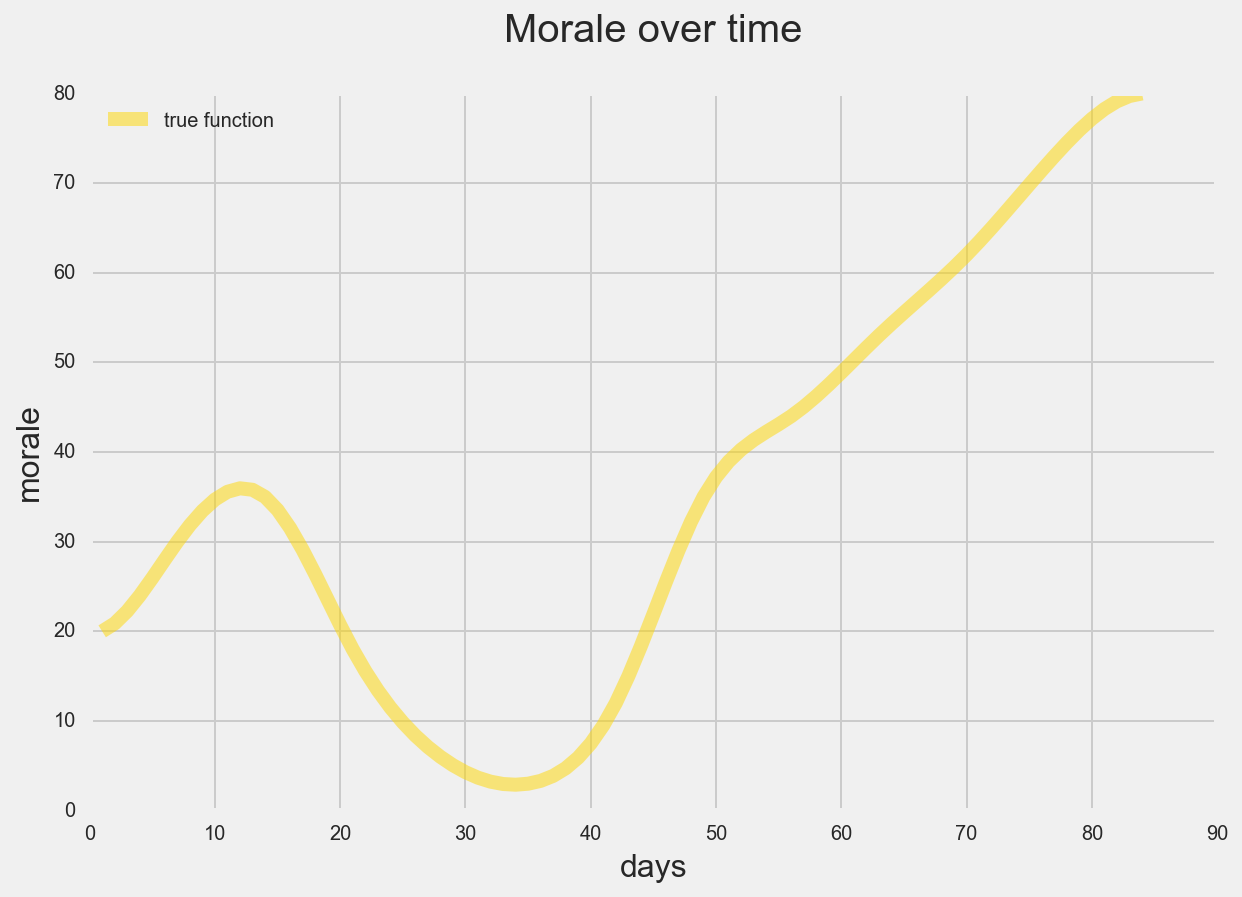

In [183]:
fig = plt.figure(figsize=(9,6))
ax = fig.gca()

ax.plot(days, morale_true, lw=7., c='gold', alpha=0.5, label='true function')

ax.set_xlabel('days', fontsize=16)
ax.set_ylabel('morale', fontsize=16)
ax.set_title('Morale over time\n', fontsize=20)

plt.legend(loc='upper left')

plt.show()

---

### Generate some fake students

Each student has had their morale checked 12 different times throughout the course, but not necessarily at the same times.

In [184]:
def make_students(f, days, size=12):
    students = {}
    for student in ['A','B','C','D']:
        daysamp = np.random.choice(days, replace=False, size=size)
        morales = f(daysamp) + np.random.normal(0,13,size=size)
        students[student] = {'days':daysamp, 'morale':morales}
    return students
        

In [185]:
students = make_students(morale_func, days, size=12)

---

### Student A morale over time

Plot of student A's morale over the days. The true function is also plotted in yellow.

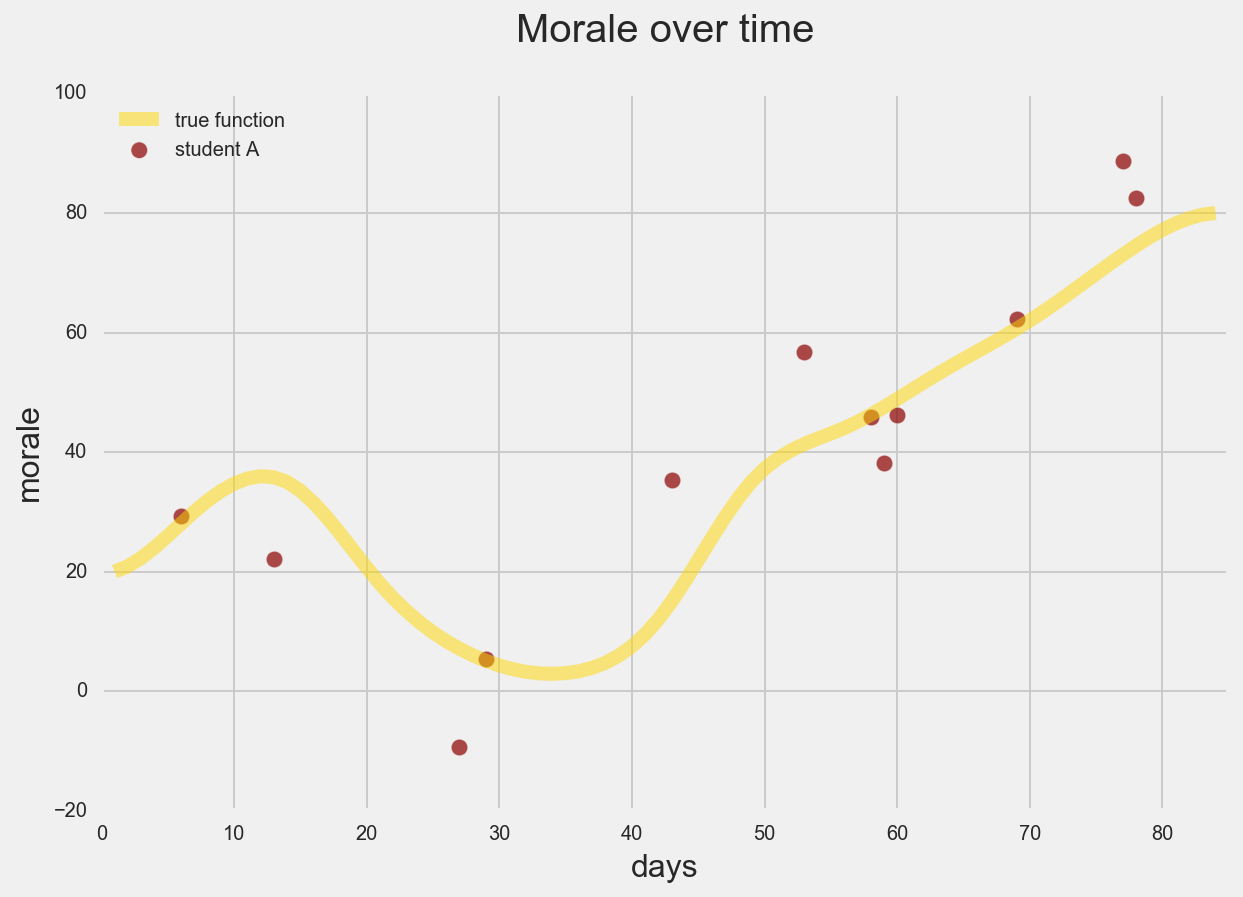

In [186]:
fig = plt.figure(figsize=(9,6))
ax = fig.gca()

ax.plot(days, morale_true, lw=7., c='gold', alpha=0.5, label='true function')
ax.scatter(students['A']['days'], students['A']['morale'],
           s=70, c='darkred', label='student A', alpha=0.7)

ax.set_xlabel('days', fontsize=16)
ax.set_ylabel('morale', fontsize=16)
ax.set_title('Morale over time\n', fontsize=20)
ax.set_xlim([0, 85])

plt.legend(loc='upper left')

plt.show()

---

## Constructing a model from our sample.

I decide to measure the morale with a linear regression, predicting it from the number of days. 

My model is:

### $$\hat{morale} = \beta_0 + \beta_1days$$

In [187]:
studA_days = students['A']['days']
studA_mor = students['A']['morale']

Amod = LinearRegression()
Amod.fit(studA_days[:, np.newaxis], studA_mor)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

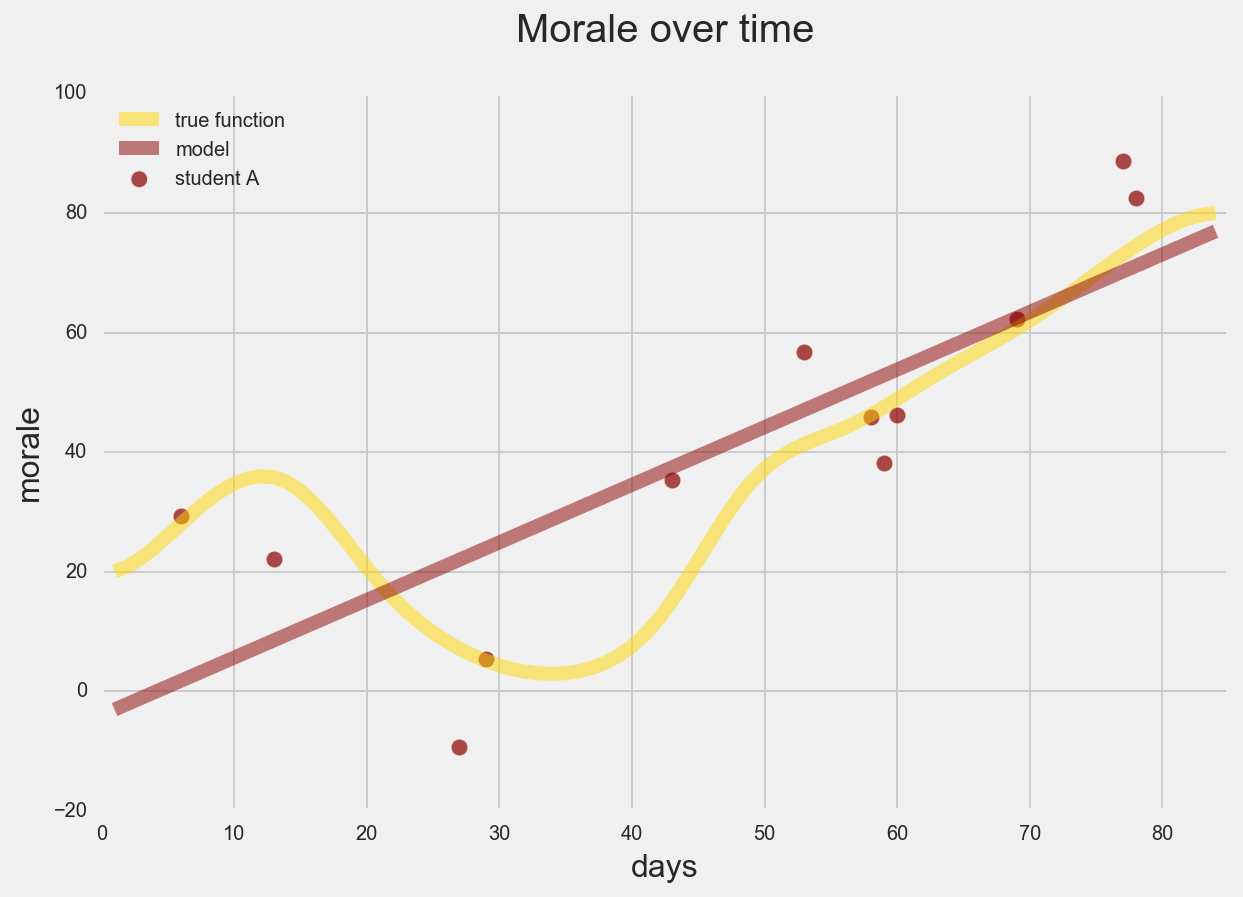

In [188]:
fig = plt.figure(figsize=(9,6))
ax = fig.gca()

ax.plot(days, morale_true, lw=7., c='gold', alpha=0.5, label='true function')

ax.plot(days, Amod.predict(days[:, np.newaxis]), lw=7., c='darkred', alpha=0.5, label='model')

ax.scatter(students['A']['days'], students['A']['morale'],
           s=70, c='darkred', label='student A', alpha=0.7)

ax.set_xlabel('days', fontsize=16)
ax.set_ylabel('morale', fontsize=16)
ax.set_title('Morale over time\n', fontsize=20)
ax.set_xlim([0, 85])

plt.legend(loc='upper left')

plt.show()

---

### Total error of model

In total we have three sources of error in our model that comprise the errors of our predictions:

### $$error = bias^2 + variance + irreducible error$$

---

### Bias

The $bias^2$ is one source of error in our model. It is the error for how much average predictions of morale across the observations at each day deviate from the true "morale function".

### $$bias^2 = \big(E[Fsamples(x_{ti})] - Ftrue(x_{ti})\big)^2$$

The squared bias is a number that essentially describes our model's assumption of how simple the true function is. 

A higher squared bias means we are assuming that variance in our prediction errors is due more to noise than _actual_ variance in the observations.

**Over multiple samples:**

Really we need to think of bias in terms of predictions we make across multiple samples. Imagine we measured 3 students rather than just 1 (we will soon). 

We calculate the bias across samples at each measurement time point. Then we can average the biases of the measurements for how biased our chosen model is in general.

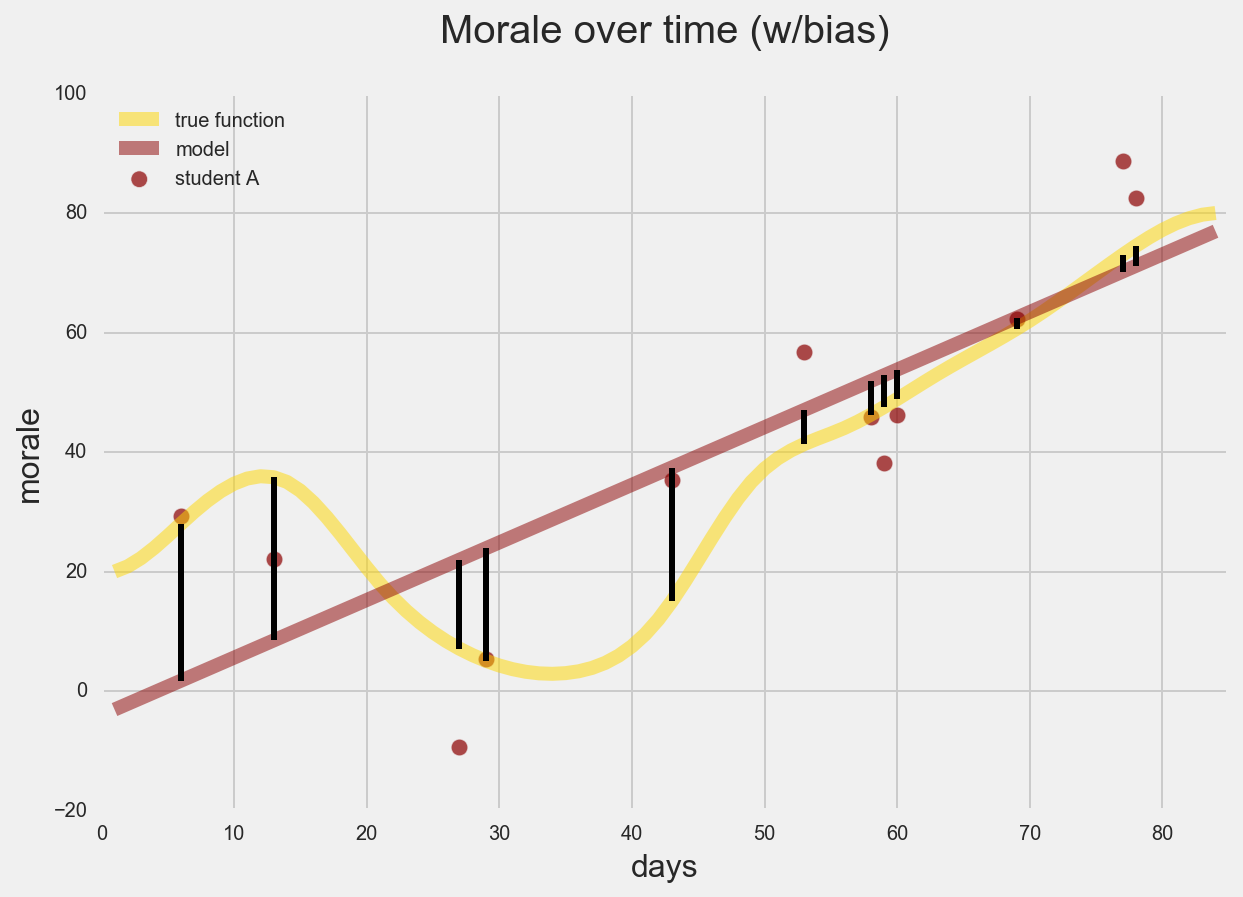

In [189]:
fig = plt.figure(figsize=(9,6))
ax = fig.gca()

ax.plot(days, morale_true, lw=7., c='gold', alpha=0.5, label='true function')

predictions = Amod.predict(days[:, np.newaxis])
ax.plot(days, predictions, lw=7., c='darkred', alpha=0.5, label='model')

ax.scatter(students['A']['days'], students['A']['morale'],
           s=70, c='darkred', label='student A', alpha=0.7)

for d in students['A']['days']:
    p = Amod.predict(d)
    ax.plot([d, d], [p, morale_func(d)], c='black', lw=3.)

ax.set_xlabel('days', fontsize=16)
ax.set_ylabel('morale', fontsize=16)
ax.set_title('Morale over time (w/bias)\n', fontsize=20)
ax.set_xlim([0, 85])

plt.legend(loc='upper left')

plt.show()

### Variance of predictions

There is another source of error in the model: the variance of our predictions. 

Variance describes how much our predictions across different samples (students) at each time deviate from the mean prediction at that time point.

### $$variance = E\bigg[\big(Fsample(x_{ti}\big) - E\big[Fsamples(x_{ti})\big])^2\bigg]$$

The variance tells us how much our model predictions change when it is fit on different sets of data.

---

### Measuring more students

To show variance, lets say we measure a second student, student "B":

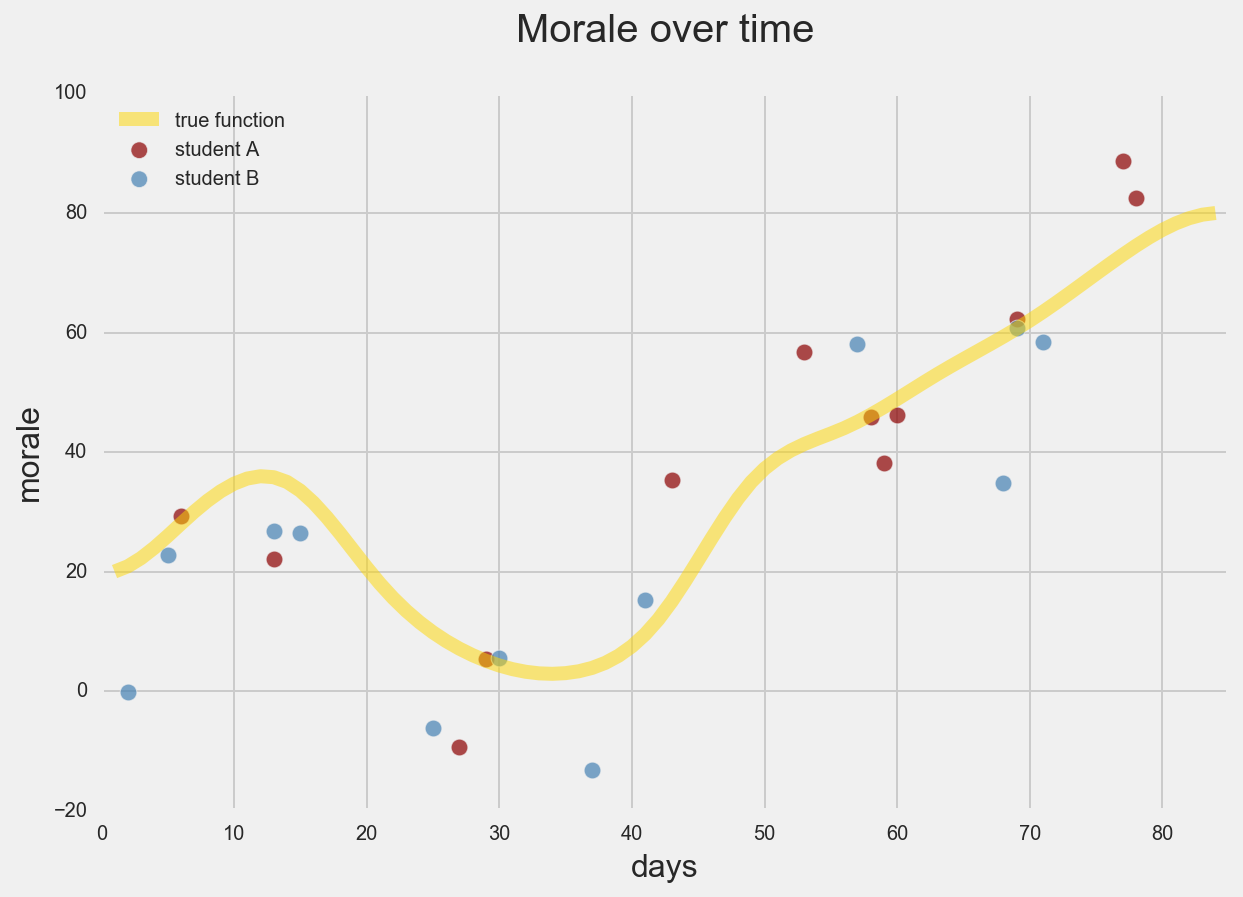

In [190]:
fig = plt.figure(figsize=(9,6))
ax = fig.gca()

ax.plot(days, morale_true, lw=7., c='gold', alpha=0.5, label='true function')

ax.scatter(students['A']['days'], students['A']['morale'],
           s=70, c='darkred', label='student A', alpha=0.7)

ax.scatter(students['B']['days'], students['B']['morale'],
           s=70, c='steelblue', label='student B', alpha=0.7)

ax.set_xlabel('days', fontsize=16)
ax.set_ylabel('morale', fontsize=16)
ax.set_title('Morale over time\n', fontsize=20)
ax.set_xlim([0, 85])

plt.legend(loc='upper left')

plt.show()

In [191]:
# Fit student b's model
studB_days = students['B']['days']
studB_mor = students['B']['morale']

Bmod = LinearRegression()
Bmod.fit(studB_days[:, np.newaxis], studB_mor)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

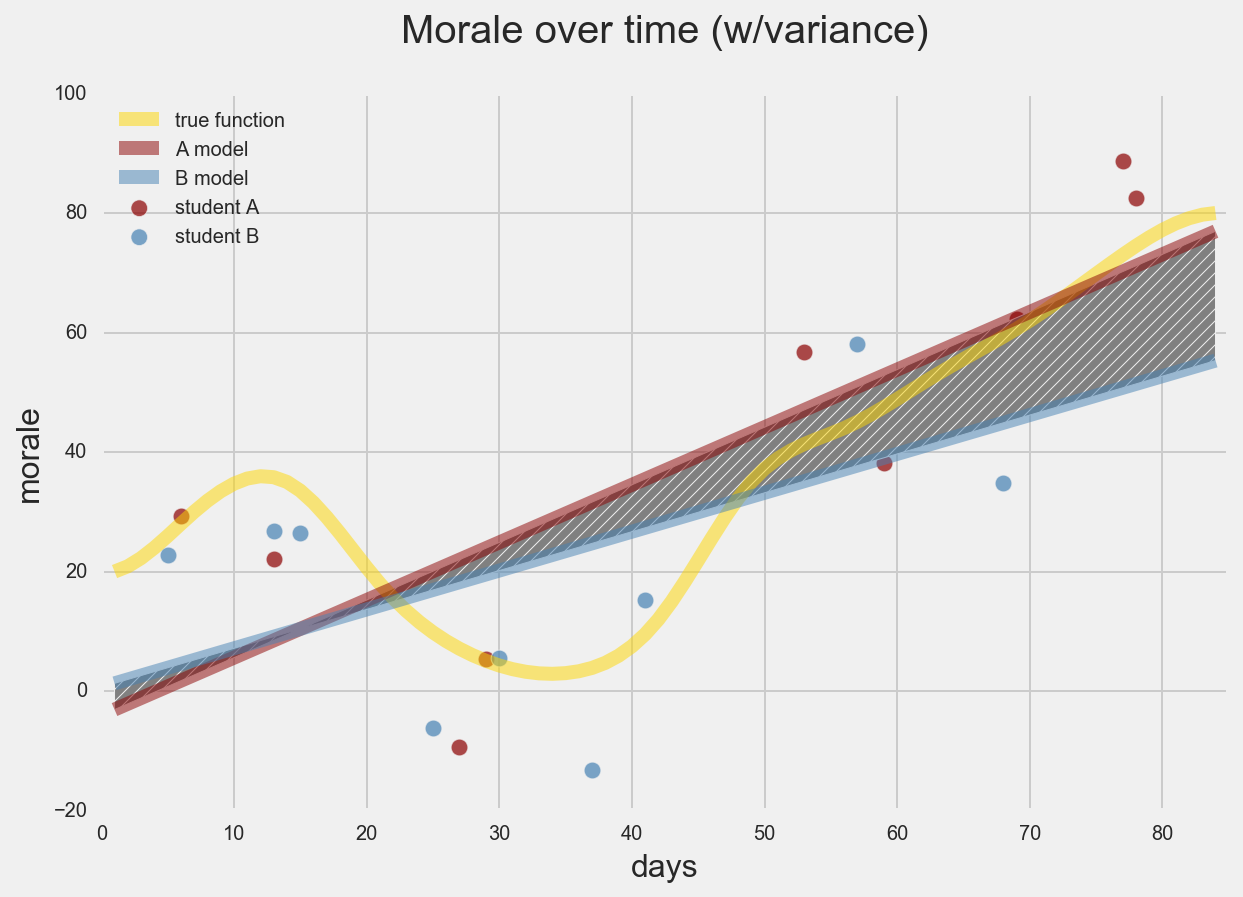

In [252]:
fig = plt.figure(figsize=(9,6))
ax = fig.gca()

ax.plot(days, morale_true, lw=7., c='gold', alpha=0.5, label='true function')

Apred = Amod.predict(days[:, np.newaxis])
ax.plot(days, Apred, lw=7., c='darkred', alpha=0.5, label='A model')

Bpred = Bmod.predict(days[:, np.newaxis])
ax.plot(days, Bpred, lw=7., c='steelblue', alpha=0.5, label='B model')

ax.scatter(students['A']['days'], students['A']['morale'],
           s=70, c='darkred', label='student A', alpha=0.7)

ax.scatter(students['B']['days'], students['B']['morale'],
           s=70, c='steelblue', label='student B', alpha=0.7)

ax.fill_between(days, Apred, Bpred, color='grey', hatch='//', edgecolor=None)

ax.set_xlabel('days', fontsize=16)
ax.set_ylabel('morale', fontsize=16)
ax.set_title('Morale over time (w/variance)\n', fontsize=20)
ax.set_xlim([0, 85])

plt.legend(loc='upper left')

plt.show()

---

### Measuring more students

Below we are now assessing the morale of 3 different students over the days in the course at different times. We can build these simple `morale ~ time` models for each and plot.

Currently, these models are **high bias and low variance**. This is because there is a large amount of difference on average between the model predictions and the true function, but not a lot of variation in predictions at time points across our models for the 3 students.

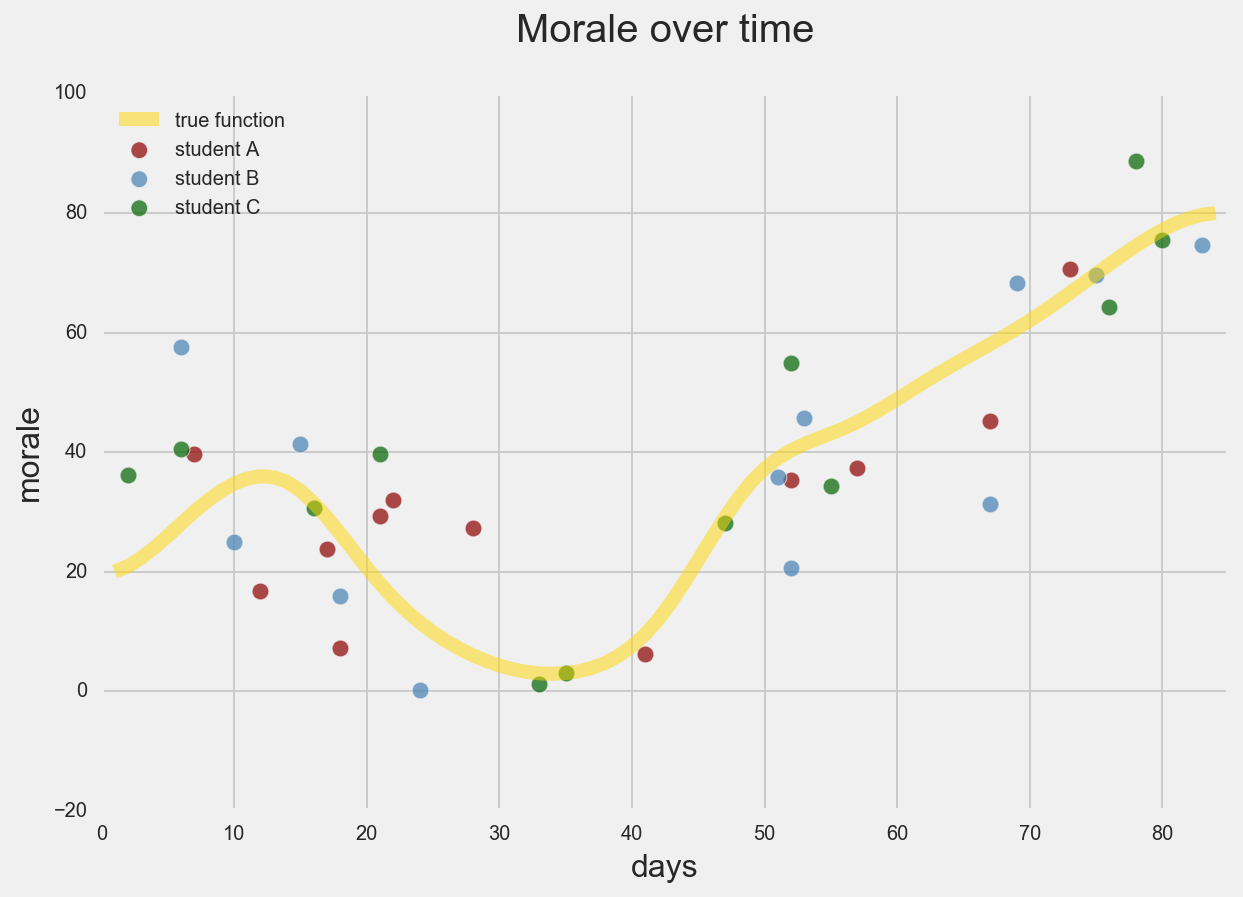

In [166]:
fig = plt.figure(figsize=(9,6))
ax = fig.gca()

ax.plot(days, morale_true, lw=7., c='gold', alpha=0.5, label='true function')

ax.scatter(students['A']['days'], students['A']['morale'],
           s=70, c='darkred', label='student A', alpha=0.7)

ax.scatter(students['B']['days'], students['B']['morale'],
           s=70, c='steelblue', label='student B', alpha=0.7)

ax.scatter(students['C']['days'], students['C']['morale'],
           s=70, c='darkgreen', label='student C', alpha=0.7)

ax.set_xlabel('days', fontsize=16)
ax.set_ylabel('morale', fontsize=16)
ax.set_title('Morale over time\n', fontsize=20)
ax.set_xlim([0, 85])

plt.legend(loc='upper left')

plt.show()

In [200]:
# Fit student C's model
studC_days = students['C']['days']
studC_mor = students['C']['morale']

Cmod = LinearRegression()
Cmod.fit(studC_days[:, np.newaxis], studC_mor)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

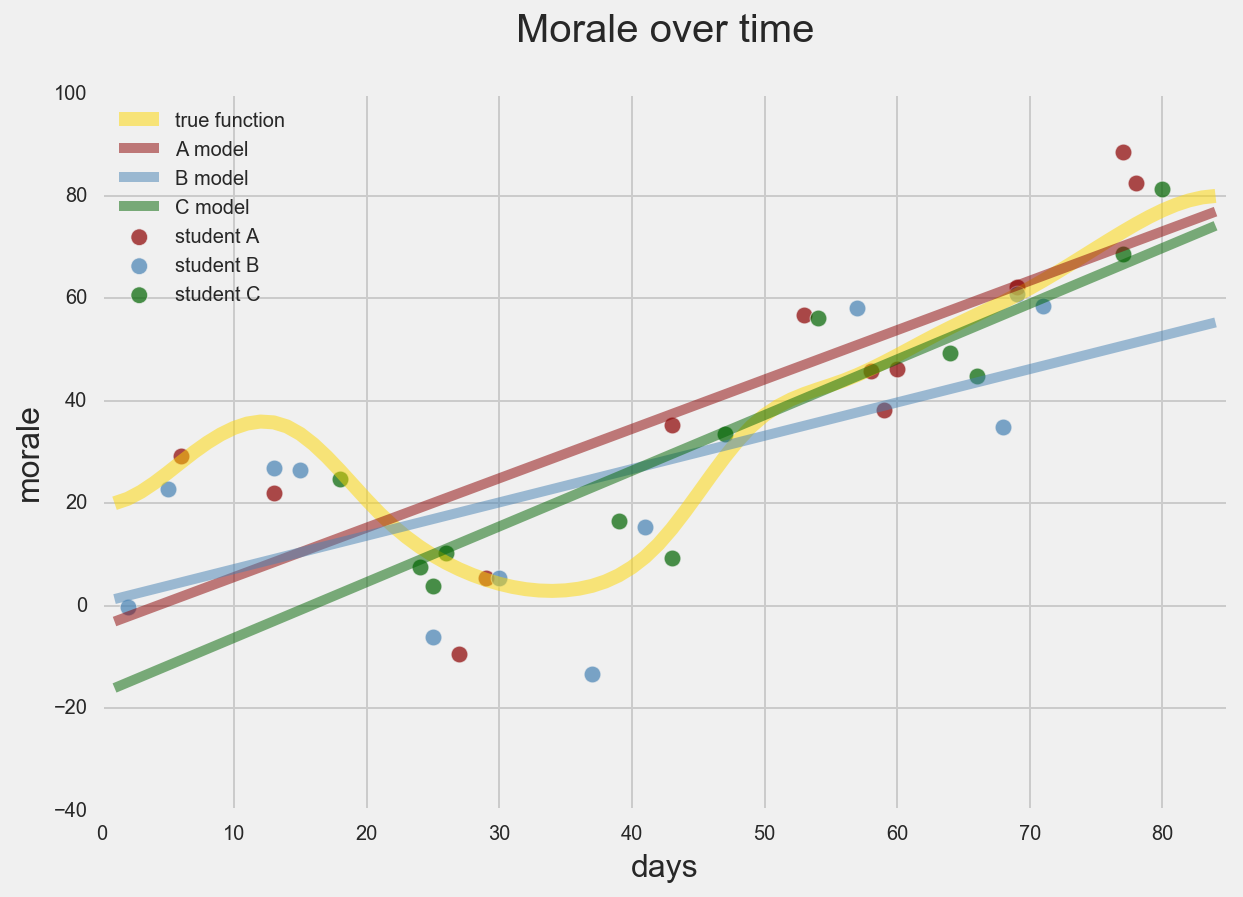

In [204]:
fig = plt.figure(figsize=(9,6))
ax = fig.gca()

ax.plot(days, morale_true, lw=7., c='gold', alpha=0.5, label='true function')

Apred = Amod.predict(days[:, np.newaxis])
ax.plot(days, Apred, lw=5., c='darkred', alpha=0.5, label='A model')

Bpred = Bmod.predict(days[:, np.newaxis])
ax.plot(days, Bpred, lw=5., c='steelblue', alpha=0.5, label='B model')

Cpred = Cmod.predict(days[:, np.newaxis])
ax.plot(days, Cpred, lw=5., c='darkgreen', alpha=0.5, label='C model')

ax.scatter(students['A']['days'], students['A']['morale'],
           s=70, c='darkred', label='student A', alpha=0.7)

ax.scatter(students['B']['days'], students['B']['morale'],
           s=70, c='steelblue', label='student B', alpha=0.7)

ax.scatter(students['C']['days'], students['C']['morale'],
           s=70, c='darkgreen', label='student C', alpha=0.7)

ax.set_xlabel('days', fontsize=16)
ax.set_ylabel('morale', fontsize=16)
ax.set_title('Morale over time\n', fontsize=20)
ax.set_xlim([0, 85])

plt.legend(loc='upper left')

plt.show()

---

### Increasing the complexity of our model

Currently we are just predicting that morale increases over time. In reality though, there is an increase, then a decrease, and then an increase again. 

Just using time alone can't fit a curve since there is only one coefficient being multiplied by time to make our morale prediction. We could, however, add more variables created from time such as $time^2$, $time^3$, etc.

The charts below show the difference in the fit when you add different numbers of "polynomial" time variables:

### $$\hat{morale} = \beta_0 + \beta_1time + \beta_2time^2$$
### $$\hat{morale} = \beta_0 + \beta_1time + \beta_2time^2 + \beta_3time^3 + \beta_4time^4$$
### $$\hat{morale} = \beta_0 + \beta_1time + ... + \beta_{16}time^{16}$$

In [238]:
def polynomial_modeler(X, y, degrees):
    polynomial_features = PolynomialFeatures(degree=degrees,
                                             include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
    pipeline.fit(X[:, np.newaxis], y)
    return pipeline

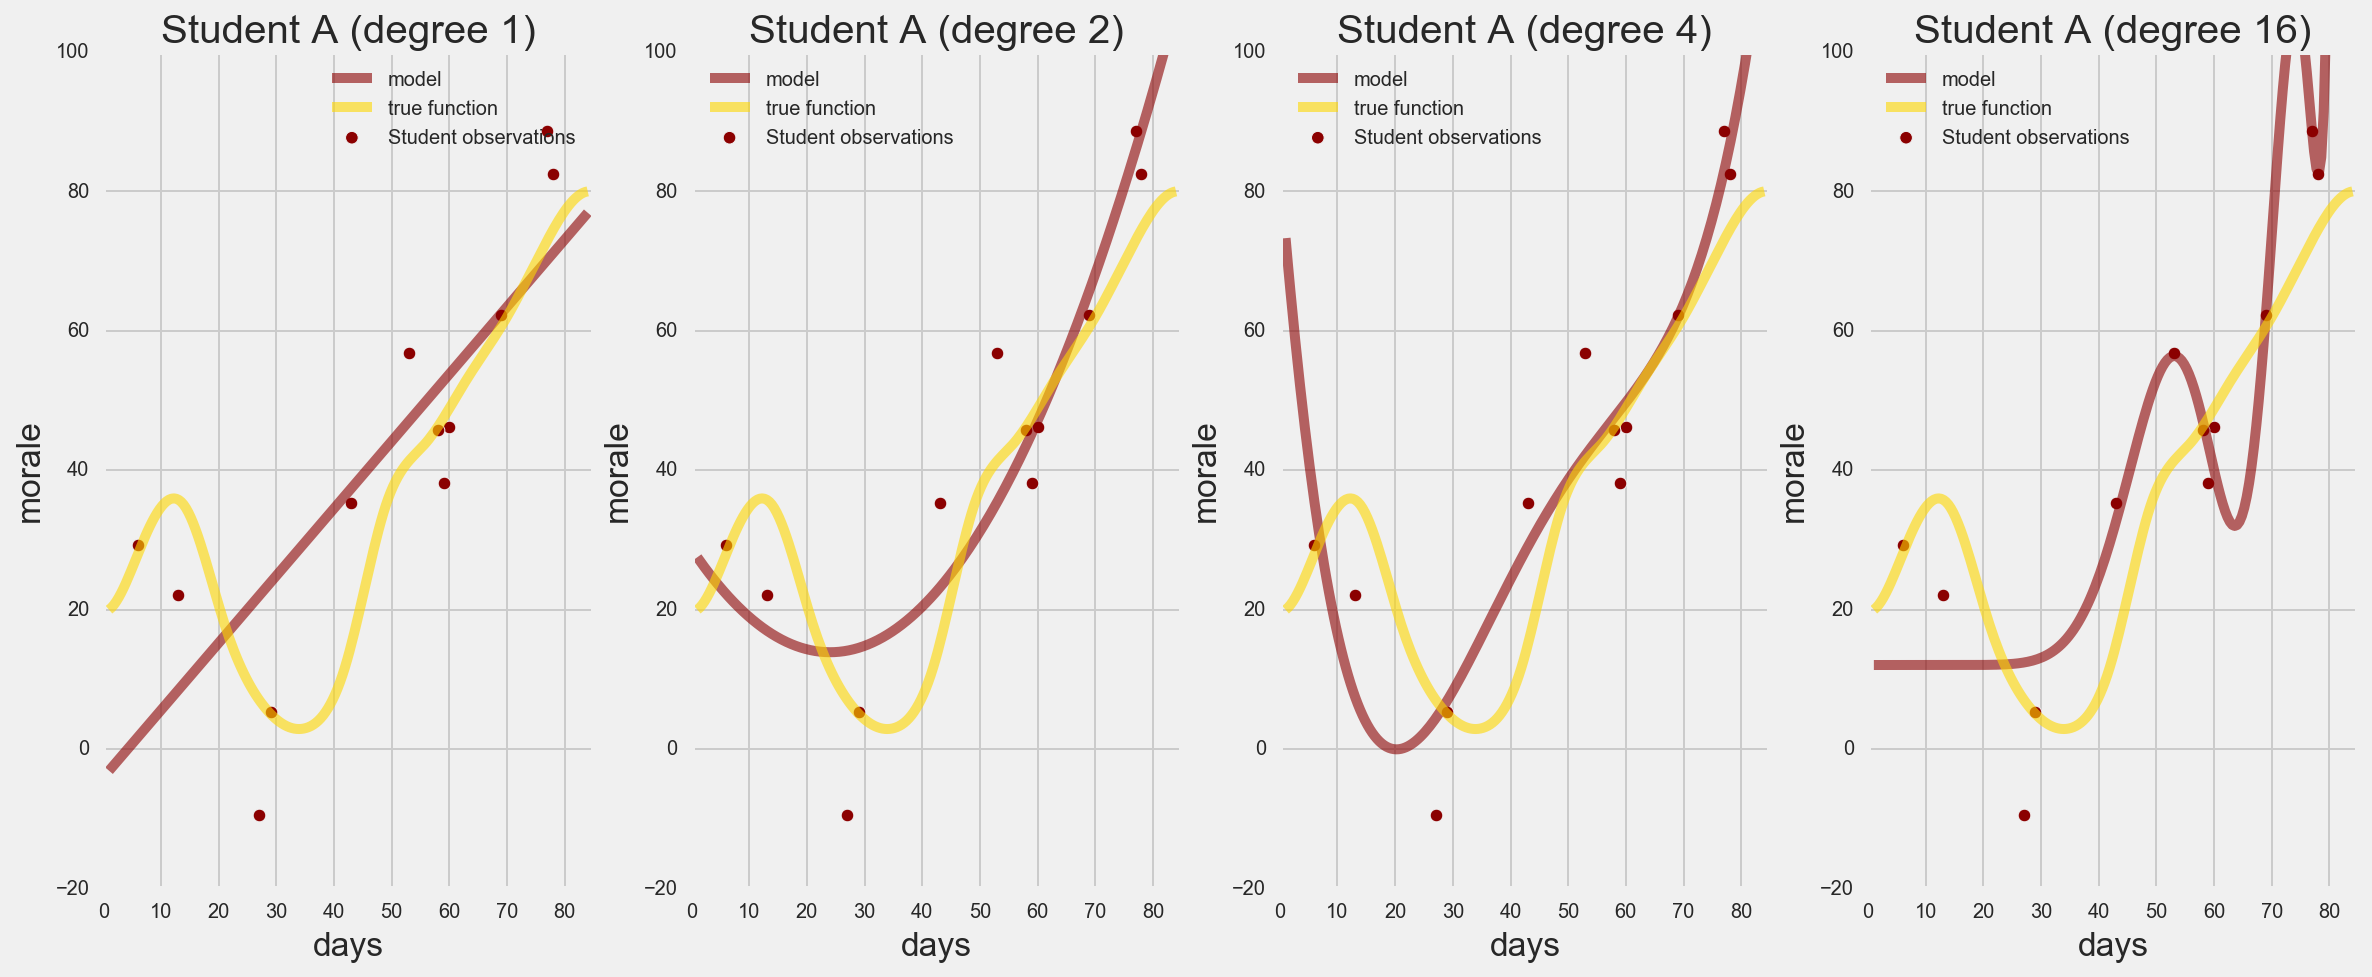

In [253]:


def plot_polyfit(X, y, truefunc, degrees=[1,2,4,16], 
                 student_color='darkred', name='A'):
    
    # set the plot size
    plt.subplots(figsize=(18,7))

    # create a plot for each polynomial degree plotted
    for i in range(len(degrees)):
        ax = plt.subplot(1, len(degrees), i + 1)
  
        poly_model = polynomial_modeler(X, y, degrees[i])

        X_test = np.linspace(1, 84, 200)
        plt.plot(X_test, poly_model.predict(X_test[:, np.newaxis]), lw=5.,
                 c=student_color, label="model", alpha=0.6)
        plt.plot(X_test, truefunc(X_test), lw=5., c='gold', alpha=0.6, label='true function')
        plt.scatter(X, y, label="Student observations", c=student_color, s=40)
        plt.xlabel("days")
        plt.ylabel("morale")
        plt.xlim((0, 85))
        plt.ylim((-20, 100))
        plt.legend(loc="best")
        
        plt.title('Student '+name+" (degree {})".format(degrees[i]))
        
plot_polyfit(students['A']['days'], students['A']['morale'], morale_func,
             student_color='darkred', name='A')

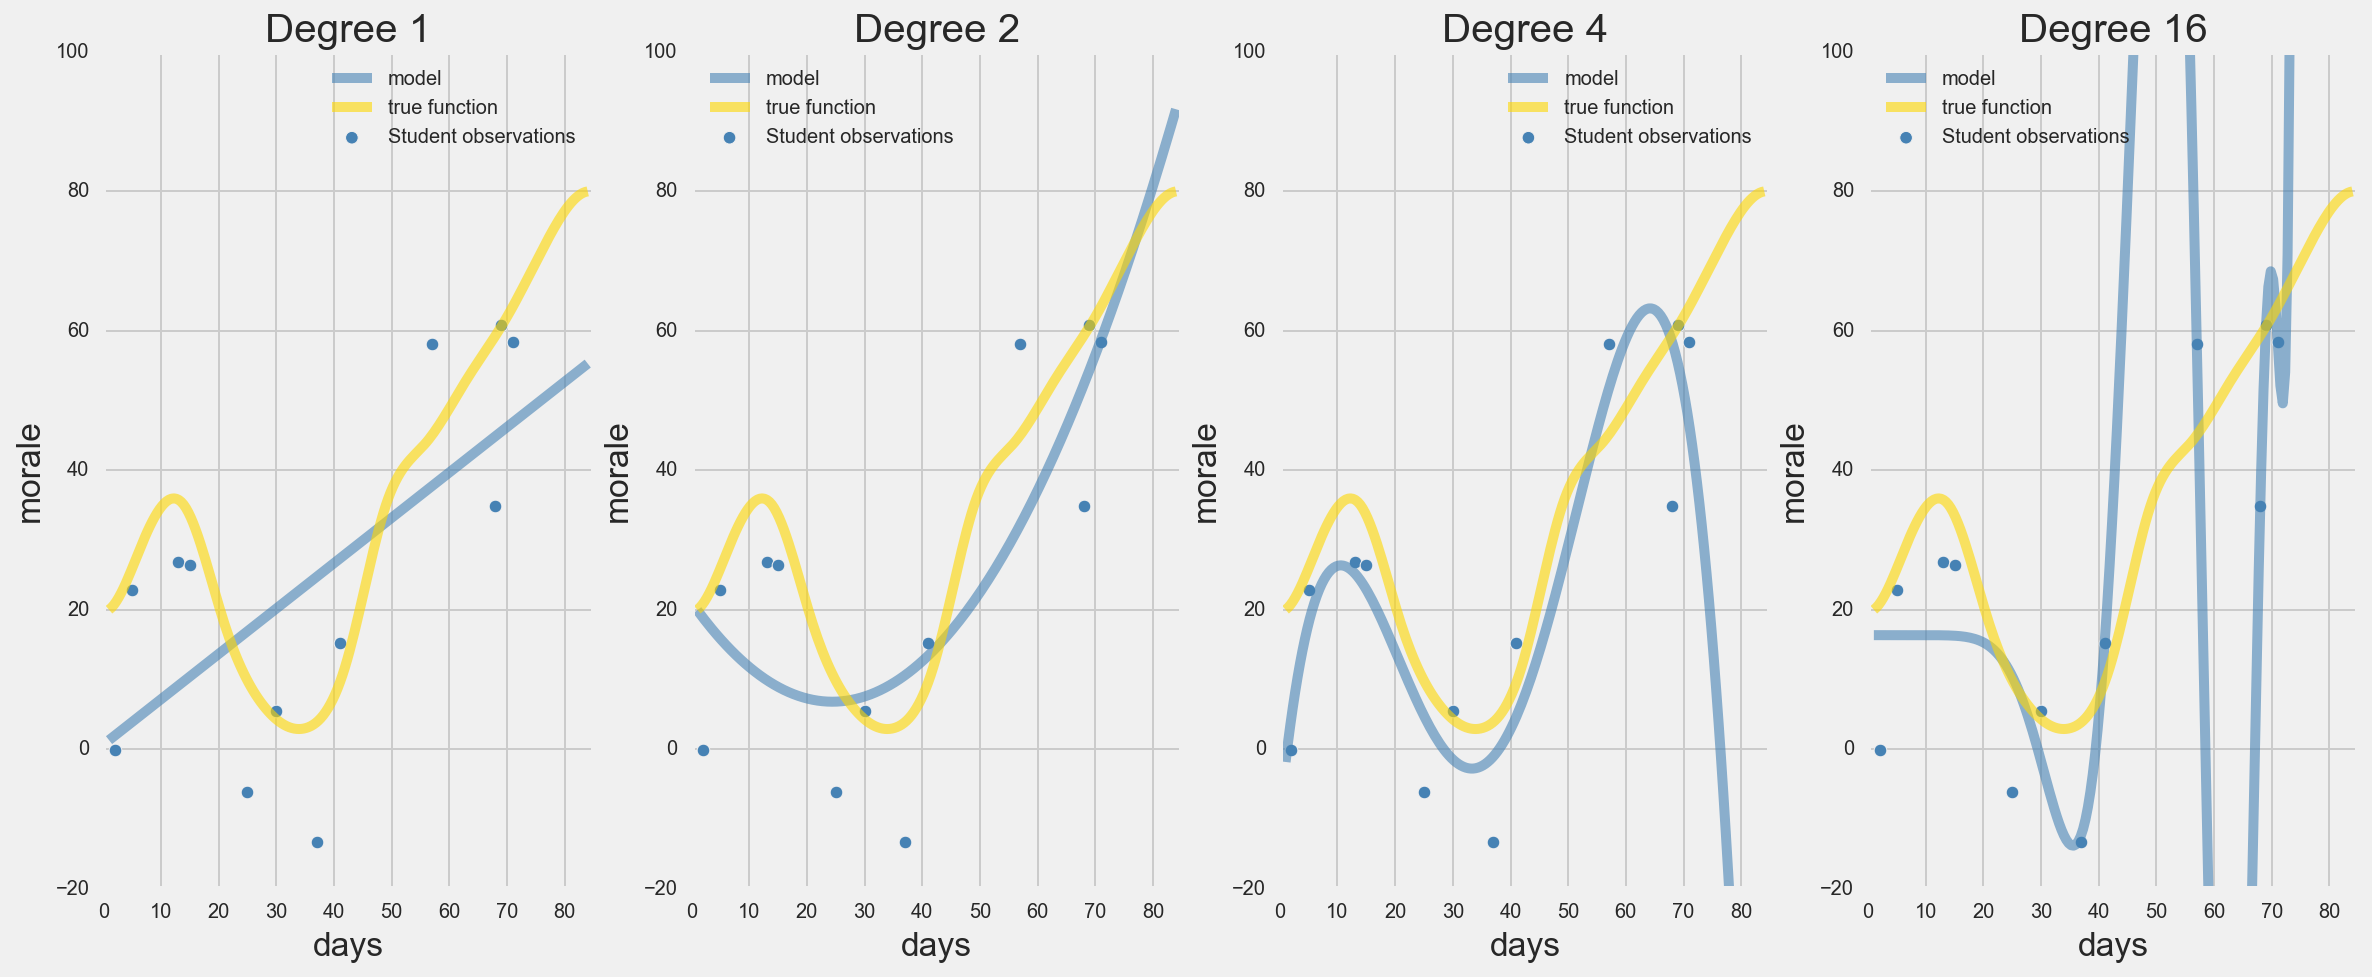

In [244]:
plot_polyfit(students['B']['days'], students['B']['morale'], morale_func,
             student_color='steelblue', name='B')

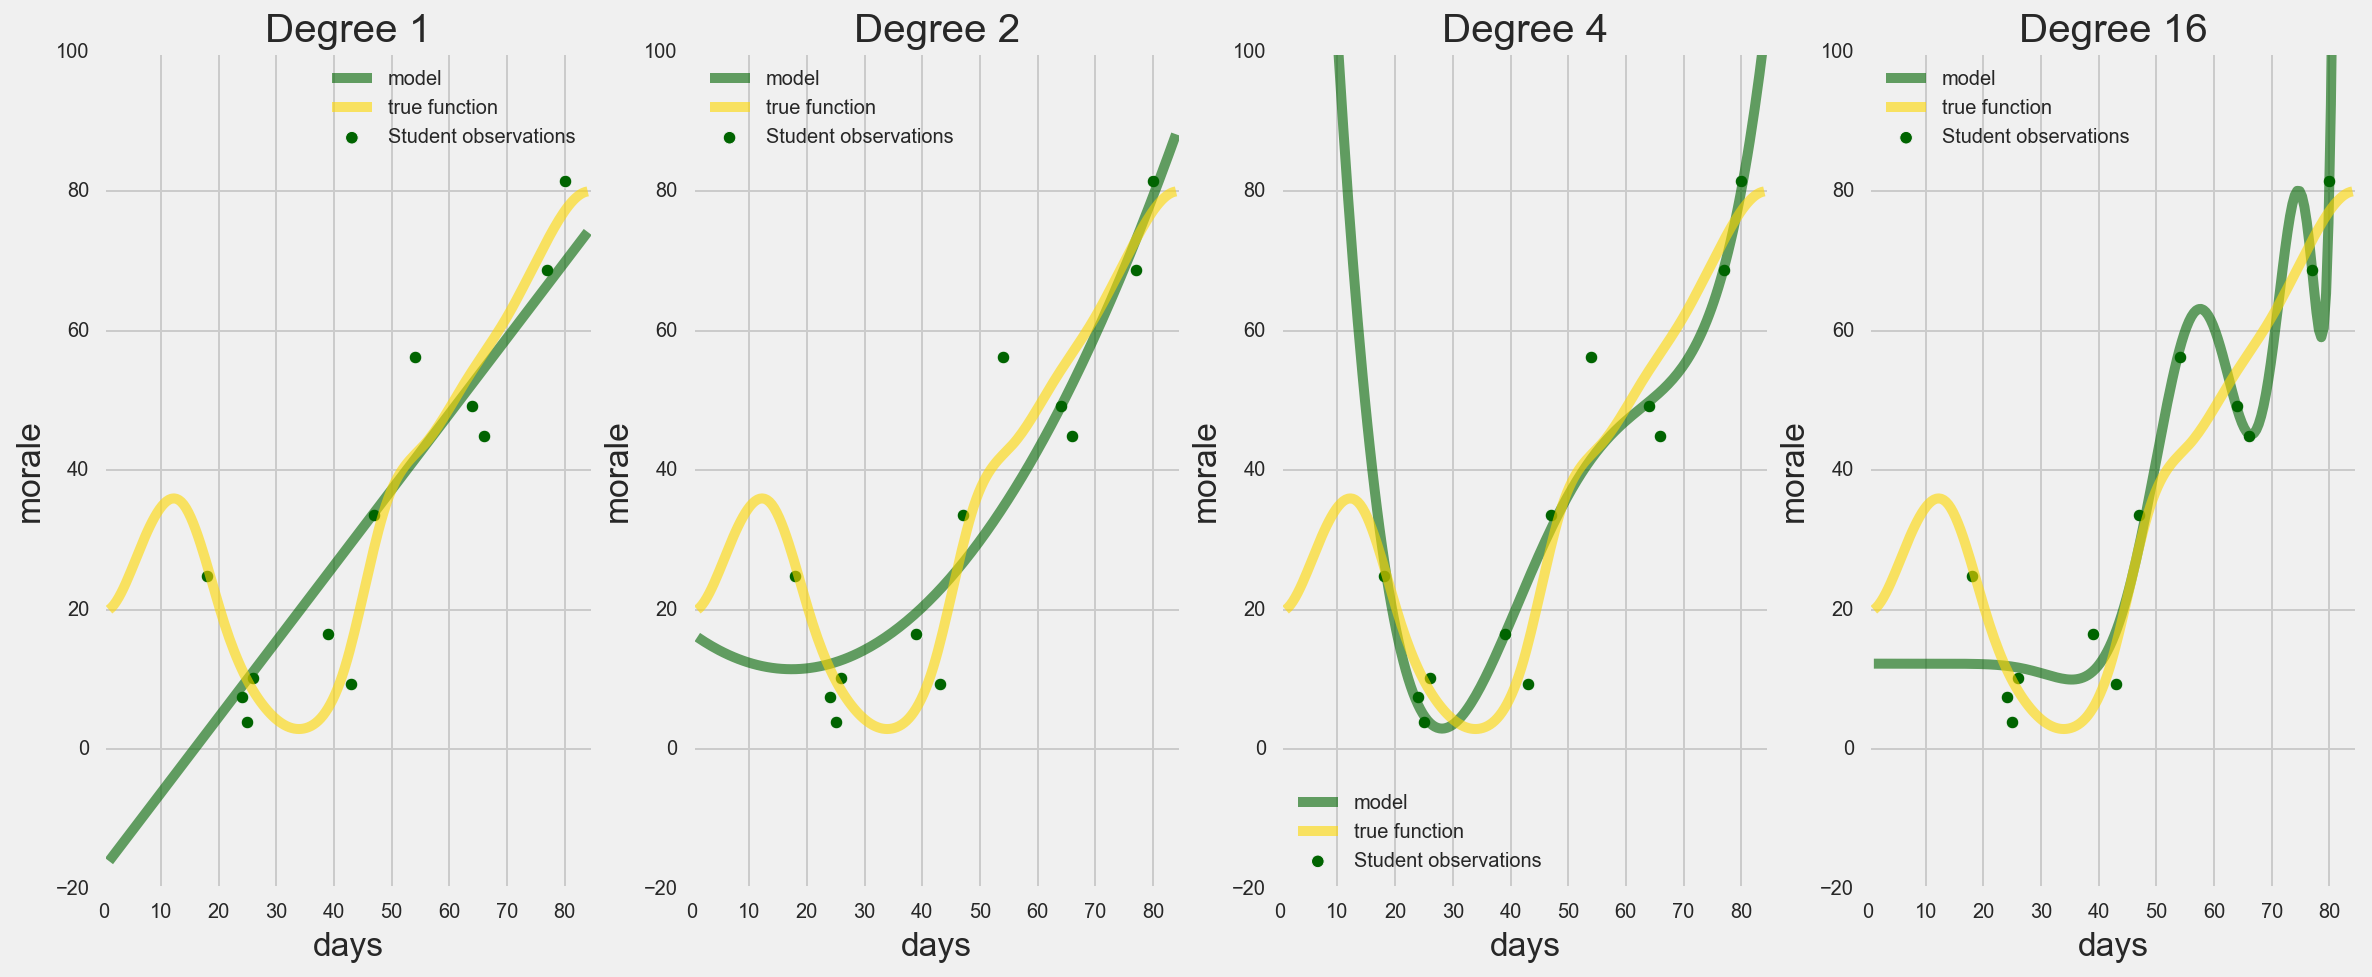

In [245]:
plot_polyfit(students['C']['days'], students['C']['morale'], morale_func,
             student_color='darkgreen', name='C')

---

### Variance with high-complexity model

The variance between predictions typically goes up with increase in model complexity. In the extreme case this is "overfitting" the data.

Below is student A and student B fit with the 16-polynomial time model and the area contributing to the variance term. Compare this to the area we saw earlier with the single time term.

With an overfit model like this, variance between predictions for morale at a specific time is very high.

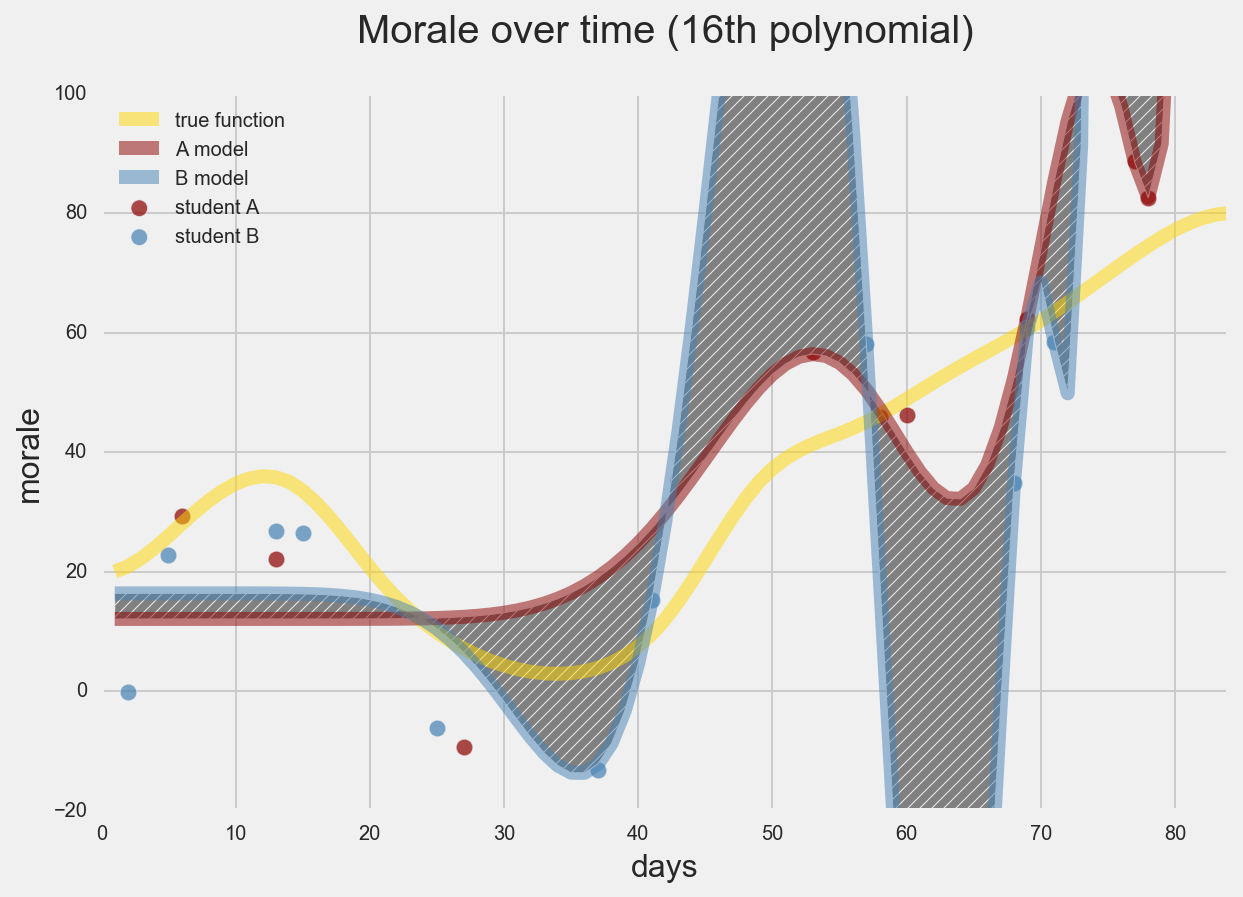

In [251]:
fig = plt.figure(figsize=(9,6))
ax = fig.gca()

ax.plot(days, morale_true, lw=7., c='gold', alpha=0.5, label='true function')

Amod_complex = polynomial_modeler(students['A']['days'], students['A']['morale'], 16)
Bmod_complex = polynomial_modeler(students['B']['days'], students['B']['morale'], 16)


Apred = Amod_complex.predict(days[:, np.newaxis])
ax.plot(days, Apred, lw=7., c='darkred', alpha=0.5, label='A model')

Bpred = Bmod_complex.predict(days[:, np.newaxis])
ax.plot(days, Bpred, lw=7., c='steelblue', alpha=0.5, label='B model')

ax.scatter(students['A']['days'], students['A']['morale'],
           s=70, c='darkred', label='student A', alpha=0.7)

ax.scatter(students['B']['days'], students['B']['morale'],
           s=70, c='steelblue', label='student B', alpha=0.7)

ax.fill_between(days, Apred, Bpred, color='grey', hatch='//', edgecolor=None)

ax.set_xlabel('days', fontsize=16)
ax.set_ylabel('morale', fontsize=16)
ax.set_title('Morale over time (16th polynomial)\n', fontsize=20)
ax.set_xlim([0, 84])
ax.set_ylim([-20,100])

plt.legend(loc='upper left')

plt.show()